In [2]:
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
import plotly.io as pio
pio.renderers.default='notebook'# to export on git and have plot shown : to have interactive = 'notebook'

In [4]:
def churn_rate_agg(x):
    return 1-x.mean()
import pycountry_convert as pc

def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    try:
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)

    except KeyError as ke:
        #only SX not found 
        country_continent_name = 'North America'
        #print('continent not found ', country_alpha2)
    return country_continent_name


# Home Exchange Presentation

https://www.homeexchange.com/


HomeExchange is a new way to travel.

<img align="left" src="homeexchange_slack.jpg" alt= “” width=400 height=400>




It is a major alternative to Airbnb where you swap houses. Registration is free, and you only pay the annual membership fee of 160€ when you find your first exchange. 

Subscription to the annual membership also give access to Guest Point (500GP for the first subscription and 250GP for the following ones). 

GuestPoints were created to enable non-reciprocal exchanges, when members cannot find someone to come to their home on the dates they would like to travel. 
Thanks to this system users are able to organize two types of exchanges on HomeExchange:

 - Reciprocal: User1 host the person (user2) whose home User1 is staying in (Users 1 and 2 are both the host and the guest)
 - Non-reciprocal: One member of the exchange is not interested in going to the other's home, in which he offer a pre-determined amount of GuestPoints per night for his hospitality (User can be either host or guest).

For example: imagine that a German couple wants to come to your home, but you wish to travel to Italy, not Germany. Without GuestPoints a simple reciprocal exchange would not be possible in that case but with GuestPoints the German couple can come stay in your home in exchange for GuestPoints. You can then use these GuestPoints to stay in a home in Italy. GuestPoints exist to compensate for the hospitality of a host.



## Problem presentation 

HomeExchange needs to understand why some of their customers leave. 

Several variables are available to identify whether seniority, activity as a guest or host, sponsorship, and subscriptions taken through promotions have an impact on the churn rate.



## Data description

Two datasets are provided by HomeExchange : 
 - **Exchanges**: 
     - One line by exchanges initiated or received by users who have register (but not necessary subscribed).
     - If exchanges is reciprocal, only one conversation is created (via the creator_id), but two exchanges are created.
     - Data : 
         - conversation_id : id of the conversation	(not unique)
         - exchange_id : exchange id which is unique, even in case of reciprocal exchange (in this case conversation_id is the same for both exchange)
         - created_at :date of conversation creation
         - creator_id :user_id of the user that who initiated the conversation
         - guest_user_id : user_id of the (potential) guest	
         - host_user_id : user_id of the (potential) host	N	
         - finalized_at : date when the exchange was finalized (if null, it means that the exchange request was not successful)	
         - canceled_at: date when the finalized exchange has been cancelled		
         - start_on: date when the exchange starts (can be filled in even if the exchange is not finalized. It corresponds to the requested dates)		
         - end_on: date when the exchange ends (can be filled in even if the exchange is not finalized. It corresponds to the requested dates)		
         - guest_count : number of people coming
         - night_count: number of nights of the exchange		
         - user_cancellation_id: user_id who canceled		
         - exchange_type: via Guest Points or reciprocal		
         - home_type: house or appartment		
         - residence_type: main or secondary house		
         - capacity: maximum number of people who can come		
         - country: host house country		
         - region: host house region		
         - department: host house department		
         - city: host house city		
 - **Subscription**: 
     - One line per subscription (for subscription > 2019). 
     - **/!\ subscription in 2019** can be a renew of a first subscription older than 2019
     - If a user has subscribed several years, there are as many lines as subscriptions. 
     - If renew = 1 , you will find the subscription line and the renewal line for the next year
     - Data : 
         - subscription_date : date of subscription of the user (can be a renew (not the first subscription))	N	
         - user_id : id of the user
         - renew : did the user re-subscribe the following year (the month of the expiration of his subscription)		
         - first_subscription_date : date of the first subscription (can be before 2019)		
         - first_subscription : 1 if it's the first subscription of the user			
         - referral : 1 if the user has been sponsored		
         - promotion : 1 if the user had a promotion for his/her subscription		
         - payment3x : 1 if the user has used the 3x payment to subscribe		
         - payment2 : 1 if the user hashas paid his/her 2nd payment		
         - payment3 : 1 if the user hashas paid his/her 3nd payment		
         - country : user country, if null, it might be a renew and the info is not saved here. Info will be retrieved in exchanges data file		
         - region : user region, if null, it might be a renew and the info is not saved here. Info will be retrieved in exchanges data file		
         - department : city : user city, if null, it might be a renew and the info is not saved here. Info will be retrieved in exchanges data file
         
         
Datasets cover period from 2019-01-01 to 2022-11-30. As subscription are for one year, the maximal date subscription date is '2021-10-31'.

Some cleaning and data enrichment was done in SQL (DBT) :
  - Cleaning : 
      - Exchange data : 
          - Remove duplicated row 
          - Remove line were host and guest was the same user 
      - Subscription data : 
          - Remove duplicated row 
          - Remove user were there were more than 3 subscriptions in 3 years (not normal since subscription are annual)
          - Add missing country, city and region info based on Exchange data (where user was host)
  - Enrichment : 
      - Subscription data, add the following information :
          - is_zombie : 1 if the user subscribe again after 1 year of absence (due to covid for example)		
          - previous_inscription_date : date of the previous subscription	
          - inscription_diff_year : difference in year between subscription_date and previous_subscription_date		
          - nb_of_inscription_by_users : nb of subscription by users between 2019 and 2021. Can only be <=3 (selection done on this key for removing strange behavior with more than 1 subscription per year)
         
**A new table was created in SQL BigQuery**

 - **User**: 
   - In this table, information such as the number of subscription of the user, the number of time the user did an exchange etc.. are summarized by users (one line per user)
   - It is an join between Subscription and Exchange table
   - Data : 
     - user_id : user_id, user can be a subscriber or not (in this case first subscription date is null)		
     - first_subscription_date : date of the first subscription (is any) of the user		
     - last_subscription_date : date of the last subscription (is any between 2019 and 2021) of the user		
     - nb_of_inscription : number of subscription of the user between 2019 and 2021 (can be more if user subscribe before 2019)	
     - mean_churn_rate : for subscription between 2019 and 2021, give the average churn rate for the user (for example, 3 subscription but only 2 renew, churn rate = 1 - 2/3 = 0.33)		
     - referall : 1 if the user were at least referall once, 0 if the user was never refer		
     - promotion : 1 if the user used at least one promotion, 0 if the user never used promotion		
     - country : country of the user		
     - nb_of_conversation_as_host : count the total number of conversation created were the user is host		
     - nb_of_conversation_as_host_notFinalized : count the total number of conversation that DID not become an exchange, were the user is host		
     - nb_of_exchange_as_host_done : count the total number of conversation that DID become an exchange and WAS NOT CANCEL, were the user is host		
     - nb_of_exchange_as_host_canceled : count the total number of conversation that DID become an exchange and WAS CANCEL, were the user is host		
     - nb_of_conversation_as_guest : count the total number of conversation created were the user is guest		
     - nb_of_conversation_as_guest_notFinalized : count the total number of conversation that DID not become an exchange, were the user is guest		
     - nb_of_exchange_as_guest_done : count the total number of conversation that DID become an exchange and WAS NOT CANCEL, were the user is guest		
     - nb_of_exchange_as_guest_canceled : count the total number of conversation that DID become an exchange and WAS CANCEL, were the user is guest		
     - nb_of_conversation_for_exchange : count the total number of conversation created for reciprocal exchange (user is both guest and host)		
     - nb_of_conversation_for_exchange_notFinalized : count the total number of conversation that DID NOT become an exchange (user is both guest and host)		
     - nb_of_exchange_as_exchange_done : count the total number of conversation that DID become an exchange and WAS NOT cancel for reciprocal exchange (user is both guest and host)		
     - nb_of_exchange_as_exchange_canceled : count the total number of conversation that DID become an exchange and WAS cancel for reciprocal exchange (user is both guest and host)
     - total_exchange_done : total of exchange done by one users during the period (2019 - 2022)


# Load data 

Subscription data : 

In [17]:
## Loadind dataset 
df_subs = pd.read_hdf('data/subscription.h5', key='data')

len_=len(df_subs)

# DONE IN SQL
# #remove multiple inscription in same year while it's an annual subscription
# multiplesub = df_subs.groupby('user_id').agg({'pk':'count', 'renew':'mean'})
# print(len(multiplesub[multiplesub.pk>=4]))
# df_subs=df_subs[~df_subs.user_id.isin(multiplesub[multiplesub.pk>=4].index.values)]
# print(round(100-(len(df_subs)/len_)*100,1), ' % of double inscription for same user in the same year')

# remove user wihtout country 
#df_subs = df_subs[df_subs.country.isnull()==False]

print('cleaning stage in SQL remove : ', round(100-len_/100000*100, 2) , '% of data')

# cast date
df_subs['first_subscription_date']= pd.to_datetime(df_subs['first_subscription_date'])
df_subs['subscription_date']= pd.to_datetime(df_subs['subscription_date'])
df_subs['previous_subscription_date']= pd.to_datetime(df_subs['previous_inscription_date'])
df_subs=df_subs.set_index('subscription_date')
# add continent info
df_subs['country'] = df_subs['country'].fillna('unknow')
df_subs['continent'] = df_subs["country"].apply(lambda x: country_to_continent(x) if x != 'unknow' else 'unknow')

cleaning stage in SQL remove :  4.37 % of data


Exchange data : 

In [6]:
df_exc = pd.read_hdf('data/exchanges.h5', key='data')
df_exc['created_at']= pd.to_datetime(df_exc['created_at'])
df_exc=df_exc.set_index('created_at')

In [7]:
# because of memory error
df_exc_1 = df_exc[df_exc.index<pd.to_datetime('2021-06-01', format='%Y-%m-%d')]

In [8]:
df_exc_2 = df_exc[df_exc.index>=pd.to_datetime('2021-06-01', format='%Y-%m-%d')]
df_exc = []

In [9]:
df_exc_monthly_1=df_exc_1.resample("M")[['exchange_id', 'finalized_at','canceled_at']].agg(['count', 'first'])
df_exc_monthly_1.columns = df_exc_monthly_1.columns.map('_'.join)
df_exc_monthly_1=df_exc_monthly_1.drop(columns='exchange_id_first')

df_exc_monthly_2=df_exc_2.resample("M")[['exchange_id', 'finalized_at','canceled_at']].agg(['count', 'first'])
df_exc_monthly_2.columns = df_exc_monthly_2.columns.map('_'.join)
df_exc_monthly_2=df_exc_monthly_2.drop(columns='exchange_id_first')

df_exc_monthly = pd.concat([df_exc_monthly_1,df_exc_monthly_2])

Users data :

In [27]:
df_users = pd.read_hdf('data/users.h5')
df_users['country'] = df_users['country'].fillna('unknow')
df_users['continent'] = df_users["country"].apply(lambda x: country_to_continent(x) if x != 'unknow' else 'unknow')

df_non_subscriber = df_users[df_users.first_subscription_date.isnull()]
df_subscriber = df_users[~df_users.first_subscription_date.isnull()]


df_non_subscriber_noexchange_atALL= df_non_subscriber[(df_non_subscriber.nb_of_exchange_as_host_done)+
                                                      (df_non_subscriber.nb_of_exchange_as_guest_done)+
                                                      (df_non_subscriber.nb_of_exchange_as_exchange_done)==0]



df_subscriber = df_subscriber.fillna(0)
df_subscriber['total_exchange_done'] = df_subscriber['nb_of_exchange_as_exchange_done'] + df_subscriber['nb_of_exchange_as_guest_done'] +  df_subscriber['nb_of_exchange_as_host_done']
df_subscriber_only_host = df_subscriber[(df_subscriber.nb_of_exchange_as_guest_done==0)
                                        &(df_subscriber.nb_of_exchange_as_host_done>0)
                                        &(df_subscriber.nb_of_exchange_as_exchange_done==0)]

df_subscriber_only_guest = df_subscriber[(df_subscriber.nb_of_exchange_as_guest_done>0)
                                        &(df_subscriber.nb_of_exchange_as_host_done==0)
                                        &(df_subscriber.nb_of_exchange_as_exchange_done==0)
                                        ]

df_subscriber_none = df_subscriber[(df_subscriber.nb_of_exchange_as_guest_done==0)
                                        &(df_subscriber.nb_of_exchange_as_host_done==0)
                                        &(df_subscriber.nb_of_exchange_as_exchange_done==0)]

df_subscriber_both = df_subscriber[(df_subscriber.nb_of_exchange_as_exchange_done>0)|
                                   ((df_subscriber.nb_of_exchange_as_guest_done>0)
                                    &(df_subscriber.nb_of_exchange_as_host_done>0))]

if (len(df_subscriber_only_host)+len(df_subscriber_only_guest)
    +len(df_subscriber_none)+len(df_subscriber_both)) != len(df_subscriber):
    print('missing data ?')
else : print('ok')

ok


# Subscription Analysis 

We first look at the subscription table which contain info for each user and for each subscription (there is one line per subscriptions (several lines for one user).

This table will allow us to do some first investigation of why or which user leave after subscribed. 
In a next section, profile of churner will be studied (using Users table) 


## Churn Rate

As renew is indicated in Subscription as 1 if the user re-subscribe and 0 if not, the churn rate can be determined as : 

**CR = 1 - mean(renew)**

which is equivalent to calculate the number of time a user that did not re-subscribe devide by the total subscribtion.


### Total churn rate

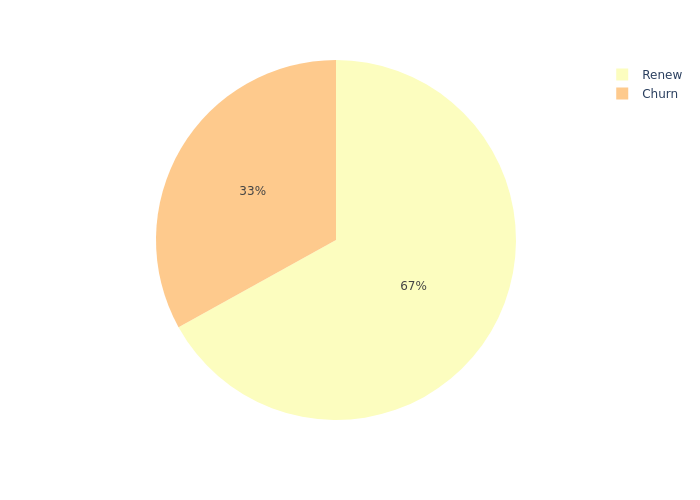

In [11]:
total_churn = round((1-df_subs[['renew']].mean()[0])*100,2)

df_churn_tot = pd.DataFrame(dict({'status':['Churn','Renew'],'value':[total_churn,100-total_churn]}))

fig = px.pie(data_frame=df_churn_tot,values='value', names='status',
             color_discrete_sequence=px.colors.sequential.Magma_r)
fig.show("png")

A total of 33% of churn is experience for the period 2019 - 2022, for all users. 

### Churn rate by country

The churn rate by continent is shown below, as well as the proportion of users that the country represent. 

In [31]:
here = df_subs.copy()

here = here.groupby('country').agg({'renew':churn_rate_agg, 'user_id':'count'}).reset_index()
here = here[here.user_id >50]
fig = px.choropleth(here,locations='country',
                         color='renew', hover_name='user_id', hover_data=['user_id'], range_color=[0,1],
                    # marker=dict(opacity=0.1), 
                       )

fig.update_layout(coloraxis_colorbar=dict(title="Churn Rate"))
fig.update_layout(title ="Churn rate by country (for country is more than 50 users)")

fig.show()

In [53]:

fig = px.line(x=df_subs.groupby('continent').agg({'user_id':'count', 'renew':churn_rate_agg}).reset_index().continent,
              y=df_subs.groupby('continent').agg({'user_id':'count', 'renew':churn_rate_agg}).reset_index().user_id/len(df_subs)*100, 
              range_y=[0,100],
              labels=dict(x="Continent", y="%", color=""),
              color=px.Constant("Proportion of users"),markers=True, )

fig.update_traces(line_color='black', line_width=2)

#px.bar(barmode='group', title ='',range_y=[0,100],)

fig.add_bar(x=df_subs.groupby('continent').agg({'user_id':'count', 'renew':churn_rate_agg}).reset_index().continent,
            y=df_subs.groupby('continent').agg({'user_id':'count', 'renew':churn_rate_agg}).reset_index().renew*100, 
            name='Churn Rate')

fig.update_yaxes(title_text="%")
fig.update_xaxes(title_text="Continent")

fig.show()


  - South America has the highest churn rate, but with a very low number of users. 
  - Europe and North America represent the largest proportion of users. 
  - European have a highest churn rate compare to North America. This is due to the fact that North American may tend to take out a subscription before finding an exchange and/or renew without even having taken advantage of their subscription :
     - **I suspect that North Amrican does have automatic renew while European have not.**
     - This can be verify by looking at the churn rate for USA's users vs France's users that did 0 exchange during the all 2019-2022 period and that still renew their subscription : 

In [54]:
test = df_subscriber[(df_subscriber.country=='USA') & (df_subscriber.total_exchange_done==0)]
usa_churn = np.average(test.mean_churn_rate,weights=test.nb_of_inscription)

test = df_subscriber[(df_subscriber.country=='FRA') & (df_subscriber.total_exchange_done==0)]
french_churn = np.average(test.mean_churn_rate,weights=test.nb_of_inscription)

df= pd.DataFrame(dict({'country':['USA','France'],'mean_churn_rate':[usa_churn, french_churn]}))

fig = px.bar(barmode='group', title ='',range_y=[0,100],)

fig.add_bar(x=df.country,
            y=df.mean_churn_rate*100,
            name='Churn Rate')


fig.update_yaxes(title_text="Mean churn rate (%)")
fig.update_xaxes(title_text="Country")

fig.update_layout(title ="Mean churn rate for users with 0 exchange between 2019 and 2022")

fig.show()

The churn rate for users that did 0 exchange between 2019 and 2022 is much smaller for USA's users compare to French's users

## Churn rate as a function of time

In [56]:

df_monthly  = df_subs.resample("2W").agg({'user_id': 'count', 'renew':'mean',
                                          'first_subscription':'mean',
                                                'is_zombie':'mean','promotion':'mean'})


In [57]:
df_monthly = df_monthly.rename(columns={"user_id": "subscription_count", 
                                        "renew": "churn_percentage", 
                                        "is_zombie":"return_percentage"})



In [59]:
# Create figure with secondary y-axis
fig = make_subplots()#specs=[[{"secondary_y": True}]])
fig2 = make_subplots()#specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df_monthly.index, y=df_monthly.subscription_count, 
               name="Subscription Count",
               line = dict(color='firebrick', width=3, dash='dot')),
    secondary_y=False,
)


fig2.add_trace(
    go.Scatter(x=df_monthly.index,
               y=(df_monthly.first_subscription)*100, name="First inscription rate (%)"))


fig2.add_trace(
    go.Scatter(x=df_monthly.index+pd.offsets.DateOffset(years=1),
               y=(1-df_monthly.churn_percentage)*100 , name="Churn rate (%)"),)

fig2.add_trace(
    go.Scatter(x=df_monthly.index,
               y=(df_monthly.return_percentage)*100 , name="Return rate (%)"),)



# Set y-axes titles
fig.update_yaxes(title_text="#", secondary_y=False)
fig.update_yaxes(range=[0,4000], secondary_y=False)
fig2.update_yaxes(range=[0,100], secondary_y=False)
fig.update_xaxes(range=[min(df_subs.index),max(df_subs.index)+pd.offsets.DateOffset(years=1)])
fig2.update_xaxes(range=[min(df_subs.index),max(df_subs.index)+pd.offsets.DateOffset(years=1)])

# specify the corners of the rectangles
covid_range = [dict(type="rect", xref="x", yref="y",
         x0="2020-03-01",y0="0",x1="2020-06-01",y1="5000",
         fillcolor="orange",opacity=0.4,line_width=0,layer="below"),
               dict(type="rect", xref="x", yref="y",
         x0="2020-11-01",y0="0",x1="2020-12-15",y1="5000",
         fillcolor="orange",opacity=0.4,line_width=0,layer="below") ]

covid_label = f"<br>".join([f"Covid19",f"Lookdown"])

fig.update_layout(shapes=covid_range)
fig2.update_layout(shapes=covid_range)

fig.add_annotation(x="2020-04-15", y=3000,  showarrow=False,
                        text=covid_label )
fig.add_annotation(x="2020-11-15", y=3000,  showarrow=False,
                        text=covid_label)


fig2.add_annotation(x="2020-04-15", y=60,  showarrow=False,
                        text=covid_label )
fig2.add_annotation(x="2020-11-15", y=60,  showarrow=False,
                        text=covid_label)

fig.show()
fig2.update_layout(legend=dict( yanchor="top", y=0.99,xanchor="left",x=0.01))
fig2.show()



Covid did impact the churn rate. 
Verify that Covid does impact Churn rate with Hypothesis testing 

In [ ]:
df_subs['covid_renew'] = np.where(df_subs.index +pd.offsets.DateOffset(years=1)>=pd.to_datetime('2021-04-15'), '1_post-covid','0_covid')
tab = pd.crosstab(df_subs.covid_renew,df_subs.renew)
tab

In [ ]:
import scipy.stats as stats

# CONDUCT FISHER_EXACT STATISTICAL TEST
odds_ratio, p_value = stats.fisher_exact(tab)
# PRINT OUT RESULTS
if p_value < 0.05:
    print(f'p_value: {p_value}\nResult: There is a significant difference')
else:
    print(f'p_value: {p_value}\nResult: No significant difference')

In [ ]:
# chi2 
chiRes = stats.chi2_contingency(tab)
p_value = chiRes[1]
if p_value < 0.05:
    print(f'p_value: {p_value}\nResult: There is a significant difference')
else:
    print(f'p_value: {p_value}\nResult: No significant difference')

COVID had a impact on churn rate and churner from covid period is not quit reprensentative, even if a small proportion on them get back after. 

It is difficult to make the study only on post covid subscripion (low data) 


REMOVE ONLY USER WITH FIRST INSCRIPTION DURING COVID ? => dans table user ? le mentionner ?? quelle date ? 




In [ ]:
df_subs['covid_subs'] = np.where(df_subs.index >=pd.to_datetime('2021-04-15'), '1_post-covid','0_covid')

In [ ]:
df_subs[df_subs.user_id==1749]

In [ ]:
len(df_subs[df_subs.covid_subs=='1_post-covid'])/len(df_subs)*100

In [ ]:
len(df_subs[df_subs.covid_renew=='1_post-covid'])

In [ ]:
df_subs_post_covid = df_subs[df_subs.covid_renew=='1_post-covid']
df_subs_pre_covid = df_subs[df_subs.covid_renew!='1_post-covid']
fig = px.bar(barmode='group')

fig.add_bar(x=['all time', 'Covid','Post-covid'],y=[1-df_subs.renew.mean(),
                                                       1-df_subs_pre_covid.renew.mean(),
                                                       1-df_subs_post_covid.renew.mean()])

In [ ]:
covid not representative car covid = analyse apres que post covid ? chaud pour le mean ?? 

## Churn rate as a function of user caracteristics 

### Number of inscriptions 


In [ ]:
fig = px.bar(barmode='group')
fig.add_bar(x=df_subs.groupby('first_subscription').agg({'user_id': 'count', 'renew':churn_rate_agg}).reset_index().first_subscription,
       y=df_subs.groupby('first_subscription').agg({'user_id': 'count', 
                                                    'renew':churn_rate_agg}).reset_index().renew,name='total')
fig.add_bar(x=df_subs_post_covid.groupby('first_subscription').agg({'user_id':  'count', 'renew':churn_rate_agg}).reset_index().first_subscription,
             y=df_subs_post_covid.groupby('first_subscription').agg({'user_id':  'count', 'renew':churn_rate_agg}).reset_index().renew,
           name='post-covid')
fig.add_bar(x=df_subs_pre_covid.groupby('first_subscription').agg({'user_id':  'count', 'renew':churn_rate_agg}).reset_index().first_subscription,
             y=df_subs_pre_covid.groupby('first_subscription').agg({'user_id':  'count', 'renew':churn_rate_agg}).reset_index().renew,
           name='Covid')
            

### Use of promotion


In [ ]:

test= df_subs.groupby('user_id').agg({'pk':'count', 'renew':churn_rate_agg})
fig = px.bar(barmode='group')

fig.add_bar(x=test.groupby('pk').agg({'renew':'mean'}).reset_index().pk
            ,y=test.groupby('pk').agg({'renew':'mean'}).reset_index().renew,name='total')

            

### First inscription or not 

In [ ]:
# note: different impact if the promotion was taken at the first subscription or not
test= df_subs[df_subs.first_subscription==0]#.groupby('user_id').agg({'pk':'count',
                                                #                     'renew':churn_rate_agg, 'promotion':'max'})
fig = px.bar(barmode='group')

fig.add_bar(x=test.groupby('promotion').agg({'renew':churn_rate_agg}).reset_index().promotion
            ,y=test.groupby('promotion').agg({'renew':churn_rate_agg}).reset_index().renew,
            name='not first subscription')


# note: different impact if the promotion was taken at the first subscription or not
test= df_subs[df_subs.first_subscription==1]#groupby('user_id').agg({'pk':'count', 
                                                                    # 'renew':churn_rate_agg, 'promotion':'max'})

fig.add_bar(x=test.groupby('promotion').agg({'renew':churn_rate_agg}).reset_index().promotion
            ,y=test.groupby('promotion').agg({'renew':churn_rate_agg}).reset_index().renew,name='first subscription')

            

### Referral

In [ ]:

test= df_subs.groupby('user_id').agg({'pk':'count', 'renew':churn_rate_agg, 'referral':'max'})
fig = px.bar(barmode='group')

fig.add_bar(x=test.groupby('referral').agg({'renew':'mean'}).reset_index().referral
            ,y=test.groupby('referral').agg({'renew':'mean'}).reset_index().renew,name='total')

            

# Exchange Table


SOME PLOT ABOUT EXCHANGE (NOT KNOWING IF USER STAY OR NOT)

In [ ]:
df_exc_monthly

In [ ]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df_exc_monthly.index, y=df_exc_monthly.exchange_id_count, 
               name="Exchange resquest Count",
               line = dict(color='firebrick', width=3, dash='dot')),
    secondary_y=False,
)


# Add traces
fig.add_trace(
    go.Scatter(x=df_exc_monthly.set_index('finalized_at_first').sort_index().index, 
               y=df_exc_monthly.set_index('finalized_at_first').sort_index().finalized_at_count, 
               name="Exchange Finalized count", ),
    secondary_y=True,
)

# Add traces
fig.add_trace(
    go.Scatter(x=df_exc_monthly.set_index('canceled_at_first').sort_index().index, 
               y=df_exc_monthly.set_index('canceled_at_first').sort_index().canceled_at_count, 
               name="Exchange Cancel count", 
             ),
    secondary_y=True,
)




# Set y-axes titles
fig.update_yaxes(title_text="#", secondary_y=False)
fig.update_xaxes(range=[min(df_exc_monthly.index),max(df_exc_monthly.index)])

# specify the corners of the rectangles
covid_range = [dict(type="rect", xref="x", yref="y",
         x0="2020-03-01",y0="0",x1="2020-06-01",y1="700000",
         fillcolor="orange",opacity=0.4,line_width=0,layer="below"),
               dict(type="rect", xref="x", yref="y",
         x0="2020-11-01",y0="0",x1="2020-12-15",y1="700000",
         fillcolor="orange",opacity=0.4,line_width=0,layer="below") ]

covid_label = f"<br>".join([f"Covid19",f"Lookdown"])

fig.update_layout(shapes=covid_range)

fig.add_annotation(x="2020-04-15", y=600000,  showarrow=False,
                        text=covid_label )
fig.add_annotation(x="2020-11-15", y=600000,  showarrow=False,
                        text=covid_label)

fig.show()


Plus d'échange finaliser après le covid !  mais pas forcement plus d'inscrit, utilisateur utile plus après le covid ? 

# Join as Users Table

SMALL STUDY ON WHY USER DO NOT SUBCRIBED


PUIS STUDY ON WHY USER THAT SUBSCRIBED LEAVE

/!\ FAIRE MEAN CHURN RATE WITH WEIGHTED 

In [ ]:

pie_df = pd.DataFrame(dict({'status':['Never Subscribe','Subscribe at least once'],
                            'value':[len(df_non_subscriber),len(df_subscriber)]}))

px.pie(data_frame=pie_df,values='value', names='status',color_discrete_sequence=px.colors.sequential.Magma_r, 
      )

In [ ]:

pie_df = pd.DataFrame(dict({'status':['Never Exchange','Exchange least once'],
                            'value':[len(df_non_subscriber[((df_non_subscriber.nb_of_exchange_as_host_done)+
                                                           (df_non_subscriber.nb_of_exchange_as_guest_done)+
                                                           (df_non_subscriber.nb_of_exchange_as_exchange_done))==0]),
                                     len(df_non_subscriber[((df_non_subscriber.nb_of_exchange_as_host_done)+
                                                           (df_non_subscriber.nb_of_exchange_as_guest_done)+
                                                           (df_non_subscriber.nb_of_exchange_as_exchange_done))>0])
                                    ]}))

px.pie(data_frame=pie_df,values='value', names='status',color_discrete_sequence=px.colors.sequential.Magma_r, )

In [ ]:
df_here = df_non_subscriber_noexchange_atALL[['user_id','country','nb_of_conversation_as_host',
                                              'nb_of_conversation_as_guest','nb_of_conversation_for_exchange']].reset_index()
df_here['conv_tot']=df_here['nb_of_conversation_as_host']+df_here['nb_of_conversation_as_guest']+df_here['nb_of_conversation_for_exchange']
df_here=df_here[['user_id','country','conv_tot']]

In [ ]:
df_here.describe()

Le 75% percentile du nombre total de conversation engagé est 21
Cela signifie que 75% des utilisateurs qui n'ont pas souscrit et qui ne sont jamais partie (ou louer leur maison) ont tenter au moins 21 conversations au total



In [ ]:
fig = px.histogram(data_frame=df_here,y='user_id',x='conv_tot', log_y=True)
fig.show()

In [ ]:
test = df_here.groupby('country').agg({'user_id':'count', 'conv_tot':'mean'}).reset_index()
total_user = np.sum(test.user_id)
print(total_user)
fig = px.bar(barmode='group')

fig.add_bar(x=test.country,y=test.user_id/total_user*100)
fig.show()


fig = px.bar(barmode='group')

fig.add_bar(x=test[(test.country=='FRA')|(test.country=='USA')].country,
            y=test[(test.country=='FRA')|(test.country=='USA')].user_id/total_user*100, name='% of users')
fig.add_bar(x=test[(test.country=='FRA')|(test.country=='USA')].country,
            y=test[(test.country=='FRA')|(test.country=='USA')].conv_tot, name='Mean nb of conversation')
fig.show()



2 fois plus de France qui ne souscrit pas que d'americain (en proportion du nb total d'utilisateur qui ne souscrit pas) 


=> RECOMMENDATION ?
- pour les inscrits qui ont tenter des conversations mais qui n'y arrive pas, envoyer un mail d'aide pour trouver des maisons 
- pour les Français, mettre en place un système qui pousse à l'inscription : 
    - avoir des maisons "caché" si pas de soucsription ? (attention au risque de non adhésions)
    - ajouter des features premium pour les inscrits ? 
    



In [ ]:
df_users[df_users.user_id==758307] #=> il doit avoir une sacré maison

In [ ]:
# subscriber user that leave

In [ ]:
print('Mean Churn rate of all subscriber', 
      round(np.average(df_subscriber.mean_churn_rate, weights=df_subscriber.nb_of_inscription)*100,2), 
      "% (over ", len(df_subscriber), ' users)')
print('Mean Churn rate of subscriber that did not made any exchange', 
      round(np.average(df_subscriber_none.mean_churn_rate, weights=df_subscriber_none.nb_of_inscription)*100,2), 
      "% (over ", len(df_subscriber_none), ' users)')

print('Mean Churn rate of subscriber that are guest and host', 
      round(np.average(df_subscriber_both.mean_churn_rate, weights=df_subscriber_both.nb_of_inscription)*100,2), 
    "% (over ", len(df_subscriber_both), ' users)')

print('Mean Churn rate of subscriber that are guest only', 
      round(np.average(df_subscriber_only_guest.mean_churn_rate, weights=df_subscriber_only_guest.nb_of_inscription)*100,2), 
     "% (over ", len(df_subscriber_only_guest), ' users)')

print('Mean Churn rate of subscriber that are host only', 
      round(np.average(df_subscriber_only_host.mean_churn_rate, weights=df_subscriber_only_host.nb_of_inscription)*100,2), 
     "% (over ", len(df_subscriber_only_host), ' users)')

In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_histogram(x=df_subscriber.total_exchange_done, histfunc='count', 
                  secondary_y=True, name='Nb of users', opacity=0.4,  )

fig.add_histogram(x=df_subscriber.total_exchange_done,y= df_subscriber.mean_churn_rate*100, histfunc='avg',name='Churn Rate')

fig.update_yaxes(type="log", secondary_y=True)

fig.update_layout(xaxis_title='Nb of exchange done by the users')

fig.update_yaxes(title_text="Churn Rate (%)", secondary_y=False)
fig.update_yaxes(title_text="Nb of users", secondary_y=True)



In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_histogram(x=df_subscriber_only_guest.total_exchange_done, histfunc='count', 
                  secondary_y=True, name='Nb of users', opacity=0.4,  )

fig.add_histogram(x=df_subscriber_only_guest.total_exchange_done,y= df_subscriber_only_guest.mean_churn_rate*100, histfunc='avg',name='Churn Rate')

fig.update_yaxes(type="log", secondary_y=True)

fig.update_layout(xaxis_title='Nb of exchange done by the users')

fig.update_yaxes(title_text="Churn Rate (%)", secondary_y=False)
fig.update_yaxes(title_text="Nb of users", secondary_y=True)



In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_histogram(x=df_subscriber_none.total_exchange_done, histfunc='count', 
                  secondary_y=True, name='Nb of users', opacity=0.4,  )

fig.add_histogram(x=df_subscriber_none.total_exchange_done,y= df_subscriber_none.mean_churn_rate*100, 
                  histfunc='avg',name='Churn Rate')

fig.update_yaxes(type="log", secondary_y=True)

fig.update_layout(xaxis_title='Nb of exchange done by the users')

fig.update_yaxes(title_text="Churn Rate (%)", secondary_y=False)
fig.update_yaxes(title_text="Nb of users", secondary_y=True)



In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_histogram(x=df_subscriber_both.total_exchange_done, histfunc='count', 
                  secondary_y=True, name='Nb of users', opacity=0.4,  )

fig.add_histogram(x=df_subscriber_both.total_exchange_done,y= df_subscriber_both.mean_churn_rate*100, 
                  histfunc='avg',name='Churn Rate')

fig.update_yaxes(type="log", secondary_y=True)

fig.update_layout(xaxis_title='Nb of exchange done by the users')

fig.update_yaxes(title_text="Churn Rate (%)", secondary_y=False)
fig.update_yaxes(title_text="Nb of users", secondary_y=True)



In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_histogram(x=df_subscriber_only_guest.total_exchange_done, histfunc='count', 
                  secondary_y=True, name='Nb of users', opacity=0.4,  )

fig.add_histogram(x=df_subscriber_only_guest.total_exchange_done,y= df_subscriber_only_guest.mean_churn_rate*100, 
                  histfunc='avg',name='Churn Rate')

fig.update_yaxes(type="log", secondary_y=True)

fig.update_layout(xaxis_title='Nb of exchange done by the users')

fig.update_yaxes(title_text="Churn Rate (%)", secondary_y=False)
fig.update_yaxes(title_text="Nb of users", secondary_y=True)



In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_histogram(x=df_subscriber_only_host.total_exchange_done, histfunc='count', 
                  secondary_y=True, name='Nb of users', opacity=0.4,  )

fig.add_histogram(x=df_subscriber_only_host.total_exchange_done,y= df_subscriber_only_host.mean_churn_rate*100, 
                  histfunc='avg',name='Churn Rate')

fig.update_yaxes(type="log", secondary_y=True)

fig.update_layout(xaxis_title='Nb of exchange done by the users')

fig.update_yaxes(title_text="Churn Rate (%)", secondary_y=False)
fig.update_yaxes(title_text="Nb of users", secondary_y=True)



In [ ]:
df_subscriber['covid'] = np.where(
                        (df_subscriber.first_subscription_date>=pd.to_datetime('2019-10-01').date())
                  & (df_subscriber.first_subscription_date<=pd.to_datetime('2020-06-01').date()), 1,0)

In [ ]:
len(df_subscriber[df_subscriber['covid']==1])/len(df_subscriber)*100

In [ ]:
test = df_subscriber[df_subscriber['covid']==0]

In [ ]:
print(len(test[test.mean_churn_rate==1])/len(test)*100)
print(len(test[test.mean_churn_rate<1])/len(test)*100)


In [ ]:
len(test[test.mean_churn_rate<1])/len(test)*100

In [ ]:
len(df_subscriber[df_subscriber.mean_churn_rate==1])/len(df_subscriber)*100

In [ ]:
len(df_subscriber[df_subscriber.mean_churn_rate==0])/len(df_subscriber)*100

In [ ]:
len(df_subscriber[round(df_subscriber.mean_churn_rate,2)==round(2/3,2)])/len(df_subscriber)*100

In [ ]:
2/3